# Little Higgs Inflation 

In this note, we evaluation the coupled equations of motion of the perturbations in the SU(5)/SO(5) Little Higgs Inflation Model proposed in (arxiv:2306.04671). 

## Scalar Perturbations

The scalar mode equations of motion are a coupled system of three equations. The Little Higgs Fluctuation is 'h', and the two gauge fluctuations are 'phi' and 'z'. We choose multiple sets of benchmark values in a wide range of the viable parameter space, and set the initial conditions by a WKB analysis.

In [1]:
# import packages
import numpy as np
from scipy.integrate import solve_ivp, complex_ode, odeint, quad
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.ticker import FuncFormatter, MultipleLocator

from scipy.optimize import fsolve

from matplotlib import rc
rc('text', usetex=True) # Use LaTeX font

# ignore the runtime warnings 
import warnings
warnings.filterwarnings('ignore')


import time
from tqdm import tqdm

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
#----------------------------#
# Constants and Coefficients #
#----------------------------#

g = np.float64(0.64) # Gauge Coupling Constants
mpl = np.float64(1.22e19) # Reduce Planck Mass [GeV]

font = {'family': 'serif',
        'color':  'grey',
        'weight': 'normal',
        'size': 25,
        }

font_legend = {'family': 'serif',
        'weight': 'normal',
        'size': 15,
        }

In [3]:
# Little Higgs Potential
def V_higgs(h, 
            model, 
            coeff, 
            V_type):
    '''
    Calculate the little Higgs potential
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full/pheno)
    '''
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl 
    f = f/mpl
    
    if V_type == 'full':
        V = mu**4*(c0 + c2*(np.sin(h/f))**2 + c4*(np.sin(h/f))**4)
    elif V_type == 'minimal':
        V = mu**4*(1+np.cos(h/f))
    else:
        raise ValueError("Potential Type Error!")
        
    return V

# Potential Derivative V,h
def Vh(h, 
       model, 
       coeff, 
       V_type):
    '''
    Calculate Hubble Parameter During the inflation
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    
    if V_type == 'full':
        Vh = mu**4*(2*c2*np.sin(h/f)*np.cos(h/f)+4*c4*np.cos(h/f)*(np.sin(h/f))**3)/f
    elif V_type == 'minimal':
        Vh = -mu**4*np.sin(h/f)/f
    else:
        raise ValueError("Potential Type Error!")
        
    return Vh

    
def Vhh(h, 
       model, 
       coeff,
       V_type):
    '''
    Calculate Hubble Parameter During the inflation
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    '''
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    if V_type == 'full':
        vhh = (2*mu**4*((c2 + c4)*np.cos(2*h/f) - c4*np.cos(4*h/f)))/f**2
    elif V_type == 'minimal':
        vhh = - mu**4*np.cos(h/f)/(f**2)
    else:
        raise ValueError("Potential Type Error!")
        
    return vhh

#Hubble Parameter
def hubble(h, 
           model, 
           coeff, 
           V_type):
    '''
    Calculate Hubble Parameter During the inflation
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    
    hub2 = V_higgs(h, model, coeff, V_type)/3
    hub = np.sqrt(hub2)
    
    return hub


# Background Gauge Field Value
def psi_bg(h, 
           model, 
           coeff, 
           V_type):
    '''
    Calculate the background gauge field value During the inflation
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    
    hub = hubble(h,model, coeff, V_type)
    lamb = g*beta 
    
    vh = Vh(h,model, coeff, V_type)
    psi_bg = (-f**2*vh/(3*g*h*hub*lamb**2))**(1/3)
    
    return psi_bg
    


# Effective Gauge Mass
def m_eff(h, 
          model, 
          coeff, 
          V_type):
    '''
    Calculate the effective gauge mass During the inflation
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    hub = hubble(h,model, coeff, V_type)
    psi = psi_bg(h,model, coeff, V_type)
    m = g*psi/hub
    
    return m

In [4]:
# Making Plots
def m_plot(model, 
          coeff, 
          V_type):
    '''
    Calculate the effective gauge mass During the inflation
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    c0, c2, c4 = coeff
    mu, beta, f = model
    mu = mu/mpl
    f = f/mpl
    lamb = g*beta 
    
    font = {'family': 'serif',
        'color':  'grey',
        'weight': 'normal',
        'size': 25,
        }
    
    num = 1000000
    
    plt.figure(figsize=(12, 7))
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('$h/f$', fontsize=20)
    plt.ylabel('$m_\psi$', fontsize=20)
    tick_pos= [np.pi/2 ,3*np.pi/4, np.pi]
    labels = ['$\pi/2$', '$3\pi/4$', '$\pi$']
    plt.xticks(tick_pos, labels)
    
    if V_type == 'full':
        x = np.linspace(np.pi/2, np.pi, num)
        plt.plot(2*(x-np.pi/2), m_eff(x*f, model, coeff, 'full'), color="black")
        y = np.linspace(0, np.pi-0.13, num)
        plt.plot(y, m_eff(y*f, model, coeff, 'minimal'))
        plt.show()
    
    elif V_type == 'minimal':
        x = np.linspace(0, np.pi-0.05, num)
        plt.plot(x, m_eff(x*f, model, coeff, 'minimal'))
        plt.show()
    else:
        raise ValueError("Potential Type Error!")
        
    print("The order of magnitude: ","%e" %(mu**4*g*lamb**2)**(-1/3))
        
#m_plot(Model_A, coeff, 'full')

In [5]:
# Background Equation of Motion for Higgs
def dot_h(h, model, coeff, V_type):
    '''
    Calculate the time derivative of the Higgs field value
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    mu, beta, f = model
    mu = mu/mpl 
    f = f/mpl
    lamb = g*beta 
    
    hub = hubble(h, model, coeff, V_type)
    psi = psi_bg(h, model, coeff, V_type)
    
    dh = (f**2/lamb**2)*(1/h)*(2*g*psi + 2*hub**2/(g*psi))
    
    return dh

def N_integrand(h,
              model, 
              coeff, 
              V_type):
    '''
    integrand of delta_N
    --------------------------------------------------
    h: background higgs field value
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    mu, beta, f = model
    mu = mu/mpl 
    f = f/mpl
    lamb = g*beta 

    hub = hubble(h, model, coeff, V_type)
    dh = dot_h(h, model, coeff, V_type)
    dN = hub/dh
    
    return dN


# Number of e-folds before the end of inflation
def delta_N(h_i,
          model, 
          coeff, 
          V_type):

    '''
    Calculate the number of e-folds before the end of inflation
    --------------------------------------------------
    h_i: background higgs field value when it cross the horizon
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    '''
    mu, beta, f = model
    mu = mu/mpl 
    f = f/mpl

    res = quad(N_integrand, h_i*f, np.pi*f, args = (model, coeff, V_type))[0]
    return res 

#  Number of e-folds  #
def N_efold(model):
    '''
    Sanity Check: Calculate the numebr of e-folds the inflation last
    --------------------------------------------------
    model: benchmark models
    '''
    mu, beta, f = model
    
    N = 60*((g/0.64)**2)*((beta/(3*10**6))**(8/3))*((mu/(8*10**6))**(4/3))
    N_alt = 60*((g/0.64)**2)*((beta/(3*10**6))**(8/3))*((f/(5*10**11))**(2/3))
    
    return N, N_alt

#print('A:'+ str(N_efold(Model_A))+'\n'+'B:'+ str(N_efold(Model_B))+'\n'+'C:'+ str(N_efold(Model_C)))

def solve_hc_higgs(model, coeff, V_type, N_ref):
    '''
    Solve for the horizon-crossing value of the higgs field 
    -------------------------------------------------------
    model: benchmark models
    coeff: coefficients for the full little higgs potential
    V_type: potential types (minimal/full)
    N_ref: number of e-folds before the end of inflation (50 or 60)
    '''
    
    function = lambda h: delta_N(h, Model_E, coeff, V_type) - N_ref
        
    root = fsolve(function, 3*np.pi/4)
        
    return root


#root = solve_hc_higgs(Model_E, coeff, 'full', 50)
#print(root)

#delta_N(root, Model_E, coeff, 'full')

In [51]:
# Load The Coefficients For A Given Set of Benchmark Values
def load_param(model, coeff, V_type, N_ref, pri = True):
    '''
    Load The Coefficients For A Given Set of Benchmark Values
    ---------------------------------------------------------
    model: benchmark models
    coeff: full potential coefficients choice
    V_type: potential types (minimal/full)
    N_ref: reference number of e-folds before the end of inflation (50 or 60)
    ---------------------------------------------------------
    Return: 
    hbar: higgs field value when horizon crossing
    vhh: V''(h) f
    Hubble: hubble parameter when horizon crossing
    psi: gauge field value when horizon crossing
    m: dimensionless effective gauge mass
    Lambda：a constant parameter (lambda^2*psi^2/f^2)
    '''
        
    mu, beta, f = model
    mu = mu/mpl 
    f = f/mpl
    
    
    if V_type == 'full':
        N = delta_N(0.5*np.pi, model, coeff, V_type)
        
    elif V_type == 'minimal':
        N = delta_N(0, model, coeff, V_type)
    
    else:
        raise ValueError("Potential Type Error!")
        
    hbar = solve_hc_higgs(model, coeff, V_type, N_ref)[0]*f
    
    vhh = Vhh(hbar, model, coeff, V_type)
    Hubble = hubble(hbar, model, coeff, V_type)
    psi = psi_bg(hbar, model, coeff, V_type)
    m = m_eff(hbar, model, coeff, V_type)
    lamb = g*beta 
    Lambda = (lamb**2/f**2)*psi
    
    gamma = Lambda*hbar*m
    Psi_c = 3*Lambda*m*psi
    Beta_c = np.sqrt(2)*Lambda*hbar*m
    nu = np.sqrt(2)*Lambda*hbar
    
    A = 1.0
    B = nu/np.sqrt(Beta_c**2 + nu**2)
    C = Beta_c/np.sqrt(Beta_c**2 + nu**2)
    
    A_prime = 1
    B_prime = 1
    C_prime = 1
    
    initial0 = [A, A_prime, B, B_prime, C, C_prime]
    
    if pri == True:
        print("#------------------------------#")
        print("#       Chosen Parameters      #")
        print("#------------------------------#")
        print(" ")
        print("Number of e-folds:", "%e" %N)
        print("Higgs Angle:", "%e" %(hbar/f))
        print("Higgs Field Value:", "%e" %hbar)
        print("Hubble Parameter:", "%e" %Hubble)
        print("2nd D of Potential:", "%e" %vhh)
        print("Psi Field Value: ", "%e" %psi)
        print("Effective Mass: ", "%e" %m)
        print("Lambda: ", "%e" %Lambda)
        print(" ")
        print("#------------------------------#")
        print("#      Initial Conditions      #")
        print("#------------------------------#")
        print(" ")
        print(" h  modes: ", 1)
        print("phi modes: ", B)
        print(" z  modes: ", C)
        print(" ")
        print("#------------------------------#")
        print("#            Regions           #")
        print("#------------------------------#")
        print(" ")
        print("m_psi*Lambda*hbar: ", "%e" %(m*Lambda*hbar))
        #print("m_psi : ", "%e" %m)
        #print("Sqrt(2)*m_psi/H*Lambda: ", "%e" %(np.sqrt(2)*m/(Hubble*Lambda)))
        
    return N, hbar, vhh, Hubble, psi, m , Lambda, initial0

load_param(Model_E, coeff, 'full', 50)

#------------------------------#
#       Chosen Parameters      #
#------------------------------#
 
Number of e-folds: 1.452245e+18
Higgs Angle: 3.141240e+00
Higgs Field Value: 2.574787e-02
Hubble Parameter: 6.720044e-21
2nd D of Potential: 2.016428e-34
Psi Field Value:  1.047602e-15
Effective Mass:  9.977100e+04
Lambda:  1.596673e+12
 
#------------------------------#
#      Initial Conditions      #
#------------------------------#
 
 h  modes:  1
phi modes:  1.0022952867896388e-05
 z  modes:  0.9999999999497703
 
#------------------------------#
#            Regions           #
#------------------------------#
 
m_psi*Lambda*hbar:  4.101680e+15


(1.4522448033935299e+18,
 0.02574787249273792,
 2.0164280363061026e-34,
 6.7200444340621854e-21,
 1.0476023948318234e-15,
 99770.99694370305,
 1596673438174.9102,
 [1.0, 1, 1.0022952867896388e-05, 1, 0.9999999999497703, 1])

### Equations of Motion

In [154]:
# The ODE system for the Scalar Modes
def scalar_modes(x, 
                 var, 
                 PARAM,
                 model, 
                 coeff, 
                 V_type, 
                 N_ref,
                 scale = 1.0
                ):
    '''
    The ODE system for the Scalar Modes
    ----------------------------------
    x: time steps
    var: differential parameters
    model: benchmark models
    coeff: full potential coefficients choice
    V_type: potential types (minimal/full)
    N_ref: reference number of e-folds before the end of inflation (50 or 60)
    '''
    
    h, dh , phi, dphi, z, dz= var
    
    _, hbar, vhh, Hubble, psi, m , Lambda, _ = PARAM
    
    if scale == 1.0:
        
        dh2 = -(1-2/x**2 + vhh/(Hubble**2*x**2) + Lambda**2*hbar**2*m**2/(2*m**2+x**2)- (3*Lambda*m*psi)/x**2)*h \
        - ((2*np.sqrt(2)*Lambda*m*hbar)/x**2)*z \
        - ((np.sqrt(2)*Lambda*m*hbar)/x)*dz \
        + ((np.sqrt(2)*Lambda*m*hbar)/x)*(x**2/m**2+2)**(-1/2)*dphi \
        - (Lambda*hbar*np.sqrt(2*x**2/m**2 +4)*(m**3*x**2-m*(4*m**4+2*x**2*m**2 +x**4))/(2*m**2*x+x**3)**2)*phi
    
        dphi2 = -(1-2/(2*m**2 + x**2)+2*m**2/x**2 + 6*m**2/(2*m**2+x**2)**2) * phi \
        - (2*np.sqrt(2 + x**2/m**2)/x**2)*z \
        - ((np.sqrt(2)*Lambda*m*hbar)/x)*(x**2/m**2+2)**(-1/2) * dh \
        + (Lambda*hbar*m*np.sqrt(2*x**2/m**2+4)*(m**2*(2*m**2+x**2)+(4*m**4+2*x**2*m**2 +x**4))/(2*m**2*x+x**3)**2)*h
    
        dz2 = - (3*np.sqrt(2)*Lambda*m*hbar/x**2)*h \
        + (np.sqrt(2)*Lambda*m*hbar/x)*dh \
        - (1-(2-2*m**2)/x**2)*z \
        - (2*np.sqrt(2+x**2/m**2)/x**2)*phi 
    
    else:
        x = x*scale
        
        dh2 = -(1-2/x**2 + vhh/(Hubble**2*x**2) + Lambda**2*hbar**2*m**2/(2*m**2+x**2)- (3*Lambda*m*psi)/x**2)*h*scale**2 \
        - ((2*np.sqrt(2)*Lambda*m*hbar)/x**2)*z*scale**2 \
        - ((np.sqrt(2)*Lambda*m*hbar)/x)*dz*scale \
        + ((np.sqrt(2)*Lambda*m*hbar)/x)*(x**2/m**2+2)**(-1/2)*dphi*scale \
        - (Lambda*hbar*np.sqrt(2*x**2/m**2 +4)*(m**3*x**2-m*(4*m**4+2*x**2*m**2 +x**4))/(2*m**2*x+x**3)**2)*phi*scale**2
    
        dphi2 = -(1-2/(2*m**2+x**2)+2*m**2/x**2 + 6*m**2/(2*m**2+x**2)**2)*phi*scale**2 \
        - (2*np.sqrt(2+x**2/m**2)/x**2)*z*scale**2 \
        - ((np.sqrt(2)*Lambda*m*hbar)/x)*(x**2/m**2+2)**(-1/2) *dh*scale \
        + (Lambda*hbar*m*np.sqrt(2*x**2/m**2+4)*(m**2*(2*m**2+x**2)+(4*m**4+2*x**2*m**2 +x**4))/(2*m**2*x+x**3)**2)*h*scale**2
    
        dz2 = - (3*np.sqrt(2)*Lambda*m*hbar/x**2)*h*scale**2 \
        + (np.sqrt(2)*Lambda*m*hbar/x)*dh*scale \
        - (1-(2-2*m**2)/x**2)*z*scale**2 \
        - (2*np.sqrt(2+x**2/m**2)/x**2)*phi*scale**2 
    
    return [dh, dh2, dphi, dphi2, dz, dz2]

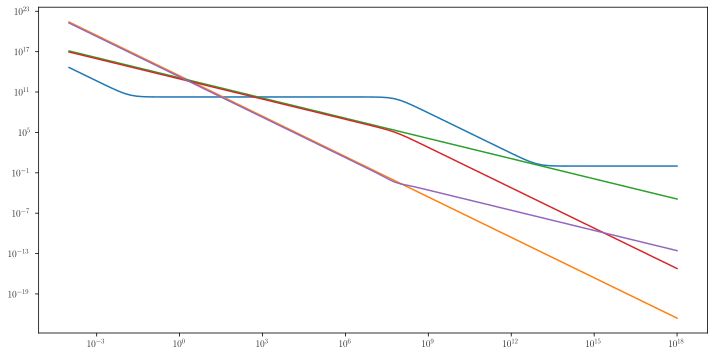

In [155]:
def coeff_func(x):
    
    PARAM = load_param(Model_E, coeff, 'full', 50, pri = False)
    _, hbar, vhh, Hubble, psi, m , Lambda, _ = PARAM
    
    ch1 = -(1-2/x**2 + vhh/(Hubble**2*x**2) + Lambda**2*hbar**2*m**2/(2*m**2+x**2)- (3*Lambda*m*psi)/x**2)
    ch2 = -((2*np.sqrt(2)*Lambda*m*hbar)/x**2)
    ch3 = - ((np.sqrt(2)*Lambda*m*hbar)/x)
    ch4 = + ((np.sqrt(2)*Lambda*m*hbar)/x)*(x**2/m**2+2)**(-1/2)
    ch5 = - (Lambda*hbar*np.sqrt(2*x**2/m**2 +4)*(m**3*x**2-m*(4*m**4+2*x**2*m**2 +x**4))/(2*m**2*x+x**3)**2)
    
    cphi1 = -(1-2/(2*m**2 + x**2)+2*m**2/x**2 + 6*m**2/(2*m**2+x**2)**2) 
    cphi2 = - (2*np.sqrt(2 + x**2/m**2)/x**2)
    cphi3 = - ((np.sqrt(2)*Lambda*m*hbar)/x)*(x**2/m**2+2)**(-1/2) 
    cphi4 = + (Lambda*hbar*m*np.sqrt(2*x**2/m**2+4)*(m**2*(2*m**2+x**2)+(4*m**4+2*x**2*m**2 +x**4))/(2*m**2*x+x**3)**2)
    
    cz1 = - (3*np.sqrt(2)*Lambda*m*hbar/x**2)
    cz2 = + (np.sqrt(2)*Lambda*m*hbar/x)
    cz3 = - (1-(2-2*m**2)/x**2)
    cz4 = - (2*np.sqrt(2+x**2/m**2)/x**2)
    
    return ch1, ch2, ch3, ch4, ch5, cphi1, cphi2, cphi3, cphi4, cz1, cz2, cz3, cz4

x_list = np.logspace(18, -4, 100)

y = coeff_func(x_list)

plt.figure(figsize=(12, 6))
plt.plot(x_list, abs(y[0]))
plt.plot(x_list, abs(y[1]))
plt.plot(x_list, abs(y[2]))
plt.plot(x_list, abs(y[3]))
plt.plot(x_list, abs(y[4]))

plt.xscale('log')
plt.yscale('log')

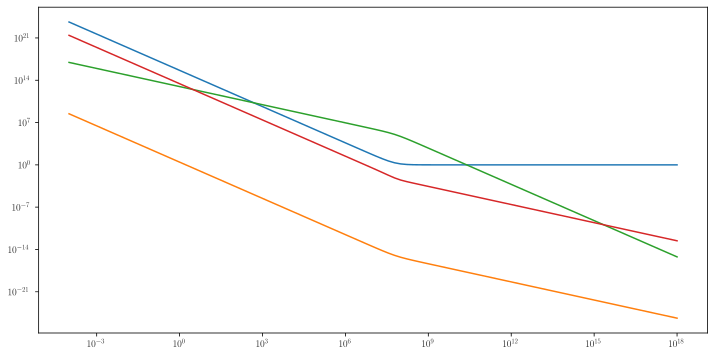

In [156]:
plt.figure(figsize=(12, 6))
plt.plot(x_list, abs(y[5]))
plt.plot(x_list, abs(y[6]))
plt.plot(x_list, abs(y[7]))
plt.plot(x_list, abs(y[8]))

plt.xscale('log')
plt.yscale('log')

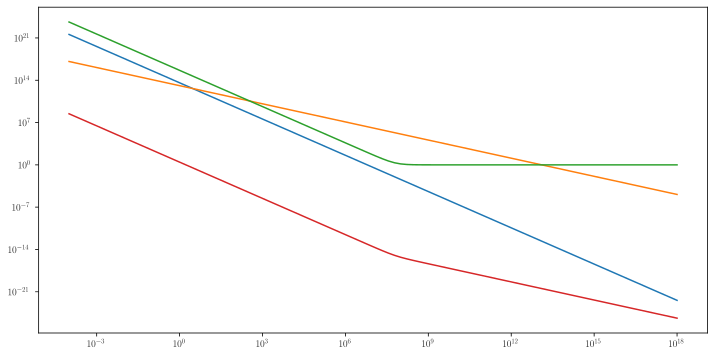

In [157]:
plt.figure(figsize=(12, 6))
plt.plot(x_list, abs(y[9]))
plt.plot(x_list, abs(y[10]))
plt.plot(x_list, abs(y[11]))
plt.plot(x_list, abs(y[12]))

plt.xscale('log')
plt.yscale('log')

In [168]:
def calculation(t_span,  
                step,
                model, 
                coeff, 
                V_type, 
                N_ref,
                method = 'LSODA'
               ):
    '''
    Solve the ODE System 
    ----------------------------------
    y0: the initial conditions
    t_span: the range of time span
    step: the number of time intervals
    model: benchmark models
    coeff: full potential coefficients choice
    V_type: potential types (minimal/full)
    N_ref: reference number of e-folds before the end of inflation (50 or 60)
    method: integration method ('RK45', 'BDF', 'Radau', 'LSODA')
    ----------------------------------
    Return: full dynamical evaluation plot
    '''
    PARAM = load_param(model, coeff, V_type, N_ref)
    
    scale = 1.0
    
    y0 = PARAM[7]
    #x_far = m*Lambda*hbar
    
    # Solve the system of equations using solve_ivp
    #t_eval = np.logspace(t_span[0], t_span[1], step)
    t_eval = np.linspace(10**t_span[0], 10**t_span[1], step)
    sol = solve_ivp(scalar_modes, [10**t_span[0],10**t_span[1]], y0 = y0, t_eval= t_eval, method = method,\
                    args = (PARAM, model, coeff, V_type, N_ref))
    
    # Extract solutions
    h_sol = abs(sol.y[0])
    phi_sol = abs(sol.y[2])
    z_sol = abs(sol.y[4])
    
    plt.figure(figsize=(15, 8))
    plt.plot(sol.t * scale, h_sol, label = '$\hat{H}$')
    plt.plot(sol.t * scale, z_sol, label = '$\hat{z}$')
    plt.plot(sol.t * scale, phi_sol, label = '$\hat\phi$')

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title('Full Dynamical Evaluation of the Scalar Modes', fontsize = 20)
    plt.xlabel('$x$', fontsize = 18)
    plt.ylabel('Amplitude', fontsize = 18)
    plt.legend(prop = font_legend)

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(sol.status)
    print(sol.message)
    print(sol.nfev)
    
    #return sol.t, h_sol, phi_sol, z_sol

def make_plots(par_lists):
    
    plt.figure(figsize=(15, 8))
    plt.plot(sol.t * scale, h_sol, label = '$\hat{H}$')
    plt.plot(sol.t * scale, z_sol, label = '$\hat{z}$')
    plt.plot(sol.t * scale, phi_sol, label = '$\hat\phi$')

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title('Full Dynamical Evaluation of the Scalar Modes', fontsize=20)
    plt.xlabel('$x$', fontsize = 18)
    plt.ylabel('Amplitude', fontsize = 18)
    plt.legend(prop = font_legend)

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()

In [169]:
#--------------------#
#  Benchmark Values  #
#--------------------#

# The ordering of the values are ['mu' (GeV), 'beta', 'f' (GeV)]

Model_A = np.array([7.8e6, 3.2e6, 5.3e11])
Model_B = np.array([1.1e8, 8.6e5, 1e14])
Model_C = np.array([3.5e9, 1.5e5, 1e17])
Model_D = np.array([1.1e8, 2e6, 1e14])
Model_E = np.array([3.5e9, 5e7, 1e17])
Model_F = np.array([3.5e9, 1e6, 1e17])
Model_G = np.array([7.8e6, 3.2e6, 5.3e11])

coeff = np.array([0.02, 1, 1])
potential_type = 'full'

# m_eff = 2.6 # Effective Gauge Mass

In [ ]:
calculation([15, -3], 10000, Model_E, coeff, 'full', 50)

#------------------------------#
#       Chosen Parameters      #
#------------------------------#
 
Number of e-folds: 3.128767e+07
Higgs Angle: 3.141233e+00
Higgs Field Value: 2.574781e-02
Hubble Parameter: 6.720045e-21
2nd D of Potential: 2.016428e-34
Psi Field Value:  4.898515e-13
Effective Mass:  4.665220e+07
Lambda:  7.465932e+06
 
#------------------------------#
#      Initial Conditions      #
#------------------------------#
 
 h  modes:  1
phi modes:  2.143521413858479e-08
 z  modes:  0.9999999999999999
 
#------------------------------#
#            Regions           #
#------------------------------#
 
m_psi*Lambda*hbar:  8.968018e+12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+16   r2 = -0.3162345444267D-04
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the

## Tensor Perturbations

In [133]:
from scipy.special import gamma
from sympy import symbols, sqrt, gamma, sinh, cosh, sec, csch, pi

In [134]:
# alpha function
def f_alpha(m_psi):
    return (2*m_psi + 1/m_psi) * 1j

# beta function
def f_beta(m_psi):
    beta_square = 2 * (1 + m_psi**2 ) - 1/4
    b = np.sqrt(beta_square)
    return b*1j

def m_tensor(m_psi):

    m = 2 * (1 + m_psi**2)
    mt = 2 * (2*m_psi + 1 / m_psi)
    
    return m , mt

def A_k(k, alpha, beta):
    coef = 1/np.sqrt(2*k)
    numerator = gamma(-alpha + beta + 1/2)
    denominator = (2j)**(-alpha) * gamma(2*beta +1)
    
    return coef*numerator/denominator

def B_k(k, alpha, beta):
    coef = 1/np.sqrt(2*k)
    numerator = gamma(-alpha + beta +1/2)*2**alphda * (1j) ** (beta +1) * (-1j) ** (alpha - beta)
    denominator = gamma(alpha + beta + 1/2)
    
    return coef*numerator/denominator
    
def I1(k, alpha, beta, m_psi):
    m, mt = m_tensor(m_psi)
    term1 = (m**2 - 2j*m*m_t + 2*m - 2*m_t**2) * sec(pi*beta) * sinh(-1j*pi*alpha) * gamma(alpha) / (2*m*(m+2))
    term2 = -pi**2 * (m**2 + 2j*m*m_t + 2*m - 2*m_t**2) * sec(pi*beta) * psi(-1j*pi*alpha) / (2*m*(m+2) * gamma(alpha+1) * gamma(-alpha-beta+0.5) * gamma(-alpha+beta+0.5))
    
    return term1 + term2

def I2(k, alpha, beta, m_psi):
    m, mt = m_tensor(m_psi)
    term1 = pi * sec(pi*beta) * gamma(-alpha) / (2 * gamma(-alpha-beta+0.5) * gamma(-alpha+beta+0.5))
    term2 = -pi * sec(pi*beta) * gamma(1-alpha) / (m * gamma(-alpha-beta+0.5) * gamma(-alpha+beta+0.5))
    term3 = (pi*m*sec(pi*beta) - 1j*pi*m_t*sec(pi*beta)) / (2*m*gamma(1-alpha))
    
    return term1 + term2 + term3

def I3(k, alpha, beta, m_psi):
    m, mt = m_tensor(m_psi)
    term1 = pi**2 * (m + 1j*m_t) * sec(pi*beta) * psi(-1j*pi*alpha) / (m*(m+2) * gamma(1j*alpha) * gamma(-alpha-beta+0.5) * gamma(-alpha+beta+0.5))
    term2 = pi * (m_t + 1j*m) * sec(pi*beta) / (m*(m+2) * gamma(-1j*alpha))
    
    return term1 + term2

In [ ]:
def tensor_r(k):
    return H**2 / (2*pi**2)

def tensor_l(k):
    return Delta_minus_sq(k) + 4*k*H**2/(pi**2) * np.abs(B_k(k))**2 * np.abs(I1(k) + m_t*I2(k) - m_t**2*I3(k))**2

# Example usage
k_value = 0.1  # Replace with the actual value of k
print("Delta_{gamma^-}^2(k) =", Delta_minus_sq(k_value))
print("Delta_{gamma^+}^2(k) =", Delta_plus_sq(k_value))